<a href="https://colab.research.google.com/github/mlabonne/how-to-data-science/blob/main/Greedy_Top_K_Search_for_GPT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greedy Top-K Search for GPT-2

❤️ Created by [@maximelabonne](https://twitter.com/maximelabonne).

In [1]:
!pip install -q transformers pydot graphviz

In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import textwrap

# Load pre-trained model and tokenizer
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

# Starting text and tokenization
text = "I have a dream"
input_ids = tokenizer.encode(text, return_tensors='pt')

# Parameters
depth = 4
k = 2

In [3]:
def score_token(logits, token_id):
    # Compute the softmax of the logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)
    
    # Get the log probability of the token
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability

def generate_text_recursively(input_ids, node, depth=5, k=2):
    if depth == 0:
        return input_ids

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    next_token_logits = predictions[0, -1, :]
    top_k_token_ids = torch.topk(next_token_logits, k).indices

    for j, next_token_id in enumerate(top_k_token_ids):
        # Compute the score of the predicted token
        token_score = score_token(next_token_logits, next_token_id)
        cumulative_score = graph.nodes[node]['cumscore'] + token_score

        # Add the predicted token to the list of input ids
        new_input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        # Add node and edge to graph
        next_token = tokenizer.decode(next_token_id)
        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]['tokenscore'] = token_score
        graph.nodes[current_node]['cumscore'] = cumulative_score
        graph.nodes[current_node]['token'] = next_token + f"_{depth}_{j}"

        # Recursive call
        input_ids = generate_text_recursively(new_input_ids, current_node, depth=depth-1, k=k)
    
    return input_ids

# Create a balanced tree with height 'depth' and branching factor 'k'
graph = nx.balanced_tree(k, depth, create_using=nx.DiGraph())

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 0
    graph.nodes[node]['cumscore'] = 0
    graph.nodes[node]['token'] = ('\n'.join(textwrap.wrap(text, 6)))

# Start generating text
generate_text_recursively(input_ids, 0, depth=depth, k=k)

tensor([[   40,   423,   257,  4320,   286,   852,   257,  6253,  4708,  1498,
           284,   290,  5033,   257,  6253, 14325,   281,  1711,  4795,    13,
           314,   423,   257,   587,   716, 18424,  5168,   198,   198,    40,
           392,    40,   423,  1101]])

<ipython-input-7-bf2e3fd65d34>:9: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")
<ipython-input-7-bf2e3fd65d34>:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, orientation='vertical', pad=0.01, label='Token log probability')


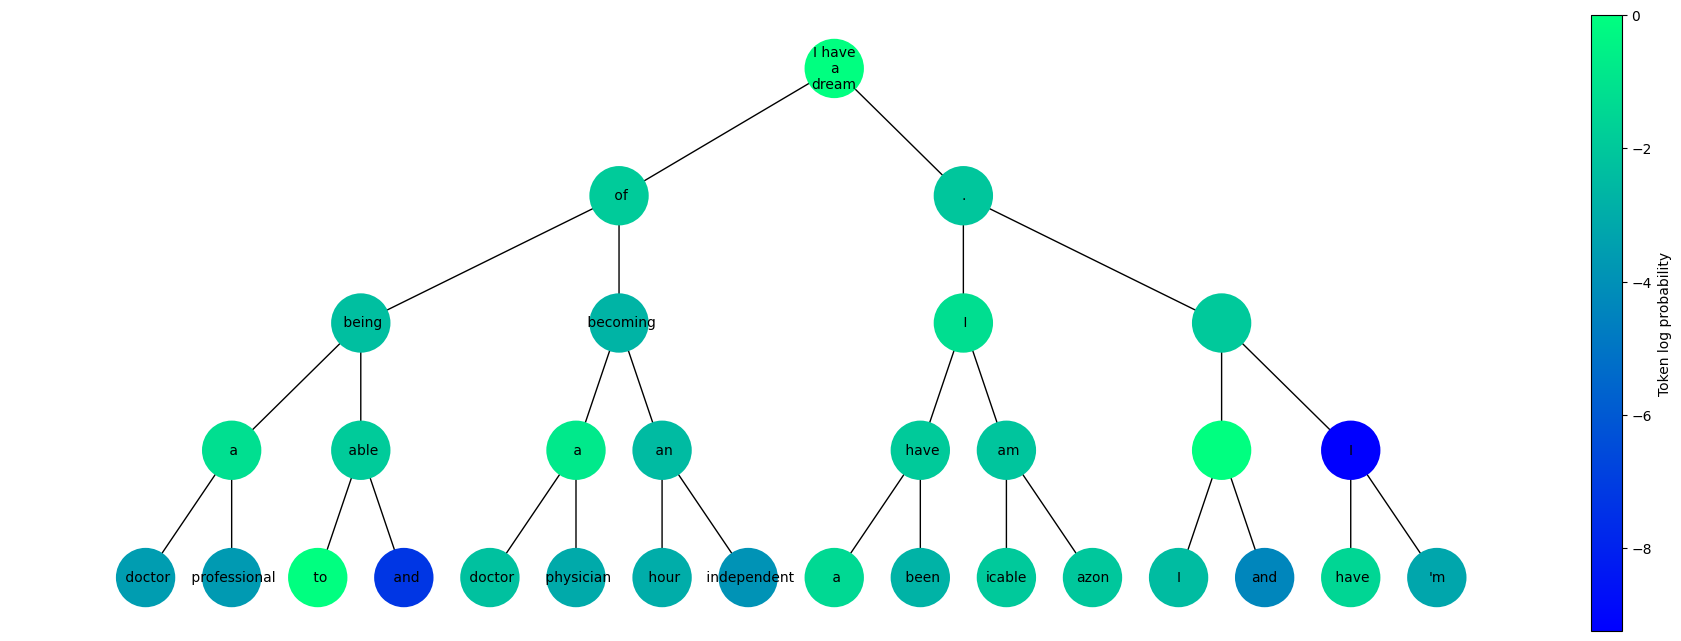

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.colors as mcolors

plt.figure(figsize=(3*depth*k, 2*depth))

# Create positions for each node
pos = graphviz_layout(graph, prog="dot")

# Normalize the colors along the range of token scores
token_scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
vmin = min(token_scores)
vmax = max(token_scores)
cmap = plt.cm.winter
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Draw the nodes
nx.draw_networkx_nodes(graph, pos, node_size=1500, node_shape='o', alpha=1, linewidths=4, 
                       node_color=token_scores, cmap=cmap)

# Draw the edges
nx.draw_networkx_edges(graph, pos)

# Draw the labels
labels = {node: data['token'].split('_')[0] for node, data in graph.nodes(data=True) if data['token'] is not None}
nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
plt.box(False)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, orientation='vertical', pad=0.01, label='Token log probability')

plt.show()